# Introduction

We decided to go with feature engineering/extraction im combination with shallow classifiers to solve the tasks of SIM1. The tasks we were facing in this exercise where the following:

1. Classify whether Kermit the frog appears in a provided frame of an episode of "The Muppet Show" or not.
2. Classify whether Waldorf & Statler appear in a provided frame of an episode of "The Muppet Show" or not.

Since Kermit the frog has a very intense green colour, we decided to try to go with colour features. More specifically, we will test the suitability of raw pixel values and colour histogram features.

For Waldorf & Statler we are going with a similar idea, but in another domain. Since Waldorf & Statler appear in certain intervals within an episode and are mostly having a short and funny scene where they speak an laugh their voices should distinguish from others quite well. Thus, we will try to extract MFCC features from audio and classify those.

# Project Structure

Directories and Files of the submission are briefly described in the following:

* **SIM1/src/SIM1.ipynb**: The jupyter notebook that holds the solutions for the modelling & classification tasks of Simimarity Modelling 1.
* **SIM1/src/SIM2.ipynb**: The jupyter notebook that holds the solutions for the modelling & classification tasks of Simimarity Modelling 2.
* **SIM1/src/labeler.py**: Small Python program we used to semi-automatically label the videos. This generates labeled images as well as a textfile with the labels per frame for the labeled video.
* **SIM1/src/audio_extractor.py**: Provides utils for extacting audio from videos.
* **SIM1/src/image_extractor.py**: Provides utils for extacting images from videos.
* **SIM1/src/dataset_generator.py**: Provides functionality for extracting the datasets for the specific prediction tasks. Those functionalities are used by the jupyter notebooks.
* **SIM1/src/requiremenets.txt**: The requirements file holding python dependencies which our solution requires
* **ground_truth/audio/mfcc.txt**: Holds the extracted MFCC features which are used for classifying Waldorf & Statler. Features are written to this file when triggered by the corresponding function of **SIM1/src/dataset_generator.py**. The MFCC dataset is sampled randomly from this file.
* **ground_truth/kermit**: This directory contains extracted and labelled images used for training and testing a model used to classify Kermit the frog. Images can be extracted using the corresonding function provided by **SIM1/src/dataset_generator.py**. Moreover, the **labels.txt** file in this directory contains a list of labels represented by episode id, frame number of the image within the episode and the label itself.
* **ground_truth/Muppets-02-01-01/Muppets-02-01-01.txt**: This textfile represents a list of labels for the episode **Muppets-02-01-01.avi**. One line of the file contains frame number of the image and the corresponding label. This file has been generated during labelling the videos using **SIM1/src/labeler.py**.
* **ground_truth/Muppets-02-04-04/Muppets-02-04-04.txt**: This textfile represents a list of labels for the episode **Muppets-02-04-04.avi**. One line of the file contains frame number of the image and the corresponding label. This file has been generated during labelling the videos using **SIM1/src/labeler.py**.
* **ground_truth/Muppets-03-04-03/Muppets-03-04-03.txt**: This textfile represents a list of labels for the episode **Muppets-03-04-03.avi**. One line of the file contains frame number of the image and the corresponding label. This file has been generated during labelling the videos using **SIM1/src/labeler.py**.
* **ground_truth/pig**: This directory contains extracted and labelled images used for training and testing a model used to classify pigs. Images can be extracted using the corresonding function provided by **SIM1/src/dataset_generator.py**. Moreover, the **labels.txt** file in this directory contains a list of labels represented by episode id, frame number of the image within the episode and the label itself.
* **ground_truth/swedish_chef**: This directory contains extracted and labelled images used for training and testing a model used to classify the Swedish Chef. Images can be extracted using the corresonding function provided by **SIM1/src/dataset_generator.py**. Moreover, the **labels.txt** file in this directory contains a list of labels represented by episode id, frame number of the image within the episode and the label itself.
* **audio/**: This directory contains labelled audio data in wav format. The filename represents {episode id}_{label}_{number of audio within episode}. This audio samples have been retrieved using **SIM1/src/dataset_generator.py** with makes use of **SIM1/src/audio_extractor.py** to cut the videos' audios according to screentime of certain characters.
* **videos/**: This directory hold the actual videos in avi format which we need to use for the similarity modelling task. It is important to place them in this ordner since all utility functions expect them to be there.


# Libraries & Definitions used for SIM1

In [4]:
import cv2 # opencv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from dataset_generator import get_waldorf_statler_mfcc_features, create_kermit_image_dataset

# definitons of constants/variables
video_file_glob_path = '../../videos/*.avi'
audio_base_path = '../../audio/'
kermit_data_path = '../../ground_truth/kermit/'
kermit_label_file = kermit_data_path + 'labels.txt'
evaluation_base_path = '../../evaluation/'

label_map = {0: 'kermit_the_frog',
             1: 'waldorf_and_statler',
             2: 'pig',
             3: 'swedish_chef',
             4: 'none'}

# Helper Functions

In the following, you can see a collection of helper functions used for the modelling task of Kermit the frog. It contains functions to load the image dataset into memory and to extract colour histograms and raw pixel values. Furthermore, we defined a function that splits the overall dataframe into train,test and validation set.

In [5]:
# method for image resizing and extracting vector of raw values
def extract_value_vector(image, size=(128, 128)):
    return cv2.resize(image, size).flatten()

def extract_colour_histogram(image, bins=(32, 32, 32)):
    # convert image to hsv space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # extract color histogram from image and take all 3 channels into account
    color_hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # normalize resulting histogram
    cv2.normalize(color_hist, color_hist)
    
    # return histogram as feature vector
    return color_hist.flatten()
    

def load_kermit_image_dataset():
    kermit_data = pd.DataFrame([], columns=['name', 'filename', 'kermit'])

    with open(kermit_label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = kermit_data_path + name + '_' + splits[2] + '.jpg'
            kermit_data = kermit_data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'kermit': 1 if 0 in labels else 0}, ignore_index=True)
    return kermit_data


def train_test_validation_split(df):
    video1_df = df[df['file_id'] == 1]
    video2_df = df[df['file_id'] == 2]
    video3_df = df[df['file_id'] == 3]
    
    train_v1_df, test_v1_df, val_v1_df = np.split(video1_df.sample(frac=1, random_state=42), [int(.6*len(video1_df)), int(.8*len(video1_df))])
    train_v2_df, test_v2_df, val_v2_df = np.split(video2_df.sample(frac=1, random_state=42), [int(.6*len(video2_df)), int(.8*len(video2_df))]) 
    train_v3_df, test_v3_df, val_v3_df = np.split(video3_df.sample(frac=1, random_state=42), [int(.6*len(video3_df)), int(.8*len(video3_df))]) 
    
    train_df = pd.concat([train_v1_df, train_v2_df, train_v3_df]).reset_index(drop=True)
    test_df = pd.concat([test_v1_df, test_v2_df, test_v3_df]).reset_index(drop=True)
    val_df = pd.concat([val_v1_df, val_v2_df, val_v3_df]).reset_index(drop=True)
    
    return train_df, test_df, val_df


# Kermit the Frog
## Train/Test/Validation Sets
For this task, we decided to go with the visual domain and extract features from labelled frames which are then used with shallow classifiers. The dataset used for Kermit's similarity modelling task combines images of all 3 videos and consists of 50% positive and 50% negative samples. The positive subset is made up of all images that have been labelled as Kermit in the labelling process. The negative samples are picked randomly from the 3 videos, but with respect of the class distribution over the 3 videos as well as within a video. For example, if Waldorf & Statler appear more oft in the first video, there will be more images of Waldorf & Statler from video 1 than from the other two. The same holds for the distribution of classes within a video. These relations have been calculated based on the size of the 50% positive Kermit samples and the actual number of negative images per class have been sampled randomly. 

The resulting dataset is loaded by our application by calling the corresponding method of **SIM1/src/dataset_generator.py** and then split into 60% traning data and 20% test and validation data each.

## Feature Extraction
Due to Kermit's distinguishable green colour, we decided to go with rather simple colour features and check if we can get good results from those. We decided to go with the following feature extraction approaches:

1) Raw pixel values
2) Colour Histogram
3) HOG


# TODO: HOG

In [12]:
# create kermit image dataset if not exists (this is checked by the function itself)
create_kermit_image_dataset()

# after dataset creation, load it into dataframe
df_kermit = load_kermit_image_dataset()

Number of samples per character in ground truth:
kermit_the_frog: 2663
waldorf_and_statler: 301
pig: 1548
swedish_chef: 220
none: 5712
total_samples: 10444
[INFO] Start extracting images for target class: 0
[INFO] Start extracting randomly sampled images


In [13]:
## Preprocessing and splitting data for Kermit
df_kermit_cp = df_kermit.copy()

# init data structures for feature vectors, image pixel values and labels
hist_features = []
images_raw_pixels = []

print('[INFO] start preprocessing images (color histogram)')

counter = 1
# iterate over all provided images and extract features, labels and image pixels
for idx, row in df_kermit_cp.iterrows():
    img = cv2.imread(row['filename'])
    print(row['filename'])
    
    # extract color distribution of the image
    img_color_hist = extract_colour_histogram(img)
    
    # extract raw pixels of the image
    img_pixels = extract_value_vector(img)

    hist_features.append(img_color_hist)
    images_raw_pixels.append(img_pixels)
    
    # show process
    if counter % 200 == 0:
        print('[INFO] images preprocessed %d/%d' % (counter, len(df_kermit_cp)))
    counter += 1
    
# add feature lists as new cols to dataframe
df_pre = df_kermit_cp.assign(color_hist = hist_features)
df_kermit_features = df_pre.assign(raw_pixels = images_raw_pixels)

# split dataframe into train, test and validation set
train, test, validation = train_test_validation_split(df_kermit_features)

# extract specific columns used for classification
x_train_raw = train['raw_pixels'].tolist()
x_train_hist = train['color_hist'].tolist()
y_train = train['kermit'].tolist()

x_test_raw = test['raw_pixels'].tolist()
x_test_hist = test['color_hist'].tolist()
y_test = test['kermit'].tolist()

x_validation_raw = validation['raw_pixels'].tolist()
x_validation_hist = validation['color_hist'].tolist()
y_validation = validation['kermit'].tolist()


[INFO] start preprocessing images (color histogram)
../../ground_truth/kermit/1_1036_0.jpg
../../ground_truth/kermit/1_1048_0.jpg
../../ground_truth/kermit/1_1060_0.jpg
../../ground_truth/kermit/1_1072_0.jpg
../../ground_truth/kermit/1_1084_0.jpg
../../ground_truth/kermit/1_1096_0.jpg
../../ground_truth/kermit/1_1108_0.jpg
../../ground_truth/kermit/1_1876_0.jpg
../../ground_truth/kermit/1_1888_0.jpg
../../ground_truth/kermit/1_1900_0.jpg
../../ground_truth/kermit/1_1912_0.jpg
../../ground_truth/kermit/1_1924_0.jpg
../../ground_truth/kermit/1_1936_0.jpg
../../ground_truth/kermit/1_1948_0.jpg
../../ground_truth/kermit/1_1960_0.jpg
../../ground_truth/kermit/1_1972_0.jpg
../../ground_truth/kermit/1_2368_0.jpg
../../ground_truth/kermit/1_2380_0.jpg
../../ground_truth/kermit/1_2392_0.jpg
../../ground_truth/kermit/1_2404_0.jpg
../../ground_truth/kermit/1_2416_0.jpg
../../ground_truth/kermit/1_2428_0.jpg
../../ground_truth/kermit/1_2440_0.jpg
../../ground_truth/kermit/1_2452_0.jpg
../../ground

../../ground_truth/kermit/1_11668_0.jpg
../../ground_truth/kermit/1_11680_0.jpg
../../ground_truth/kermit/1_11692_0.jpg
../../ground_truth/kermit/1_11704_0.jpg
../../ground_truth/kermit/1_11716_0.jpg
../../ground_truth/kermit/1_11728_0.jpg
../../ground_truth/kermit/1_11740_0.jpg
../../ground_truth/kermit/1_11752_0.jpg
../../ground_truth/kermit/1_11764_0.jpg
../../ground_truth/kermit/1_11776_0.jpg
../../ground_truth/kermit/1_11788_0.jpg
../../ground_truth/kermit/1_11800_0.jpg
../../ground_truth/kermit/1_11812_0.jpg
../../ground_truth/kermit/1_11824_0.jpg
../../ground_truth/kermit/1_11836_0.jpg
../../ground_truth/kermit/1_11848_0.jpg
../../ground_truth/kermit/1_11860_0.jpg
../../ground_truth/kermit/1_11872_0.jpg
../../ground_truth/kermit/1_11884_0.jpg
../../ground_truth/kermit/1_11896_0.jpg
../../ground_truth/kermit/1_11908_0.jpg
../../ground_truth/kermit/1_31348_0.jpg
../../ground_truth/kermit/1_31360_0.jpg
../../ground_truth/kermit/1_31372_0.jpg
../../ground_truth/kermit/1_31384_0.jpg


../../ground_truth/kermit/1_37228_0.jpg
../../ground_truth/kermit/1_37240_0.jpg
../../ground_truth/kermit/1_37252_0.jpg
../../ground_truth/kermit/1_37264_0.jpg
../../ground_truth/kermit/1_37276_0.jpg
../../ground_truth/kermit/1_37288_0.jpg
../../ground_truth/kermit/1_37300_0.jpg
../../ground_truth/kermit/1_37312_0.jpg
../../ground_truth/kermit/1_37324_0.jpg
../../ground_truth/kermit/1_37336_0.jpg
../../ground_truth/kermit/1_37348_0.jpg
../../ground_truth/kermit/1_37360_0.jpg
../../ground_truth/kermit/1_37384_0.jpg
../../ground_truth/kermit/1_37396_0.jpg
../../ground_truth/kermit/1_37420_0.jpg
../../ground_truth/kermit/1_37432_0.jpg
../../ground_truth/kermit/1_37468_0.jpg
../../ground_truth/kermit/1_37504_0.jpg
../../ground_truth/kermit/2_925_0.jpg
../../ground_truth/kermit/2_937_0.jpg
../../ground_truth/kermit/2_949_0.jpg
../../ground_truth/kermit/2_961_0.jpg
../../ground_truth/kermit/2_973_0.jpg
../../ground_truth/kermit/2_985_0.jpg
../../ground_truth/kermit/2_997_0.jpg
../../ground_t

../../ground_truth/kermit/2_8905_0.jpg
../../ground_truth/kermit/2_8917_0.jpg
../../ground_truth/kermit/2_8929_0.jpg
../../ground_truth/kermit/2_8941_0.jpg
../../ground_truth/kermit/2_8953_0.jpg
../../ground_truth/kermit/2_8965_0.jpg
../../ground_truth/kermit/2_8977_0.jpg
../../ground_truth/kermit/2_8989_0.jpg
../../ground_truth/kermit/2_9001_0.jpg
../../ground_truth/kermit/2_9013_0.jpg
../../ground_truth/kermit/2_9025_0.jpg
../../ground_truth/kermit/2_9037_0.jpg
../../ground_truth/kermit/2_9049_0.jpg
../../ground_truth/kermit/2_9061_0.jpg
../../ground_truth/kermit/2_9073_0.jpg
../../ground_truth/kermit/2_9085_0.jpg
../../ground_truth/kermit/2_9097_0.jpg
../../ground_truth/kermit/2_9109_0.jpg
../../ground_truth/kermit/2_9121_0.jpg
../../ground_truth/kermit/2_9133_0.jpg
../../ground_truth/kermit/2_9145_0.jpg
../../ground_truth/kermit/2_9157_0.jpg
../../ground_truth/kermit/2_9169_0.jpg
../../ground_truth/kermit/2_9181_0.jpg
../../ground_truth/kermit/2_9193_0.jpg
../../ground_truth/kermit

../../ground_truth/kermit/2_22369_0.jpg
../../ground_truth/kermit/2_22381_0.jpg
../../ground_truth/kermit/2_22393_0.jpg
../../ground_truth/kermit/2_22405_0.jpg
../../ground_truth/kermit/2_22417_0.jpg
../../ground_truth/kermit/2_22429_0.jpg
../../ground_truth/kermit/2_22513_0.jpg
../../ground_truth/kermit/2_22525_0.jpg
../../ground_truth/kermit/2_22537_0.jpg
../../ground_truth/kermit/2_22549_0.jpg
../../ground_truth/kermit/2_22561_0.jpg
../../ground_truth/kermit/2_22573_0.jpg
../../ground_truth/kermit/2_22585_0.jpg
../../ground_truth/kermit/2_22597_0.jpg
../../ground_truth/kermit/2_22609_0.jpg
../../ground_truth/kermit/2_22621_0.jpg
../../ground_truth/kermit/2_22633_0.jpg
../../ground_truth/kermit/2_22645_0.jpg
../../ground_truth/kermit/2_22657_0.jpg
../../ground_truth/kermit/2_22669_0.jpg
../../ground_truth/kermit/2_22681_0.jpg
../../ground_truth/kermit/2_22693_0.jpg
../../ground_truth/kermit/2_22705_0.jpg
../../ground_truth/kermit/2_22717_0.jpg
../../ground_truth/kermit/2_22729_0.jpg


../../ground_truth/kermit/2_31201_0.jpg
../../ground_truth/kermit/2_31213_0.jpg
../../ground_truth/kermit/2_31225_0.jpg
../../ground_truth/kermit/2_31237_0.jpg
../../ground_truth/kermit/2_31249_0.jpg
../../ground_truth/kermit/2_31261_0.jpg
../../ground_truth/kermit/2_31273_0.jpg
../../ground_truth/kermit/2_31285_0.jpg
../../ground_truth/kermit/2_31297_0.jpg
../../ground_truth/kermit/2_31309_0.jpg
../../ground_truth/kermit/2_31321_0.jpg
../../ground_truth/kermit/2_31333_0.jpg
../../ground_truth/kermit/2_31345_0.jpg
../../ground_truth/kermit/2_31357_0.jpg
../../ground_truth/kermit/2_31369_0.jpg
../../ground_truth/kermit/2_31381_0.jpg
../../ground_truth/kermit/2_31393_0.jpg
../../ground_truth/kermit/2_31405_0.jpg
../../ground_truth/kermit/2_31417_0.jpg
../../ground_truth/kermit/2_31429_0.jpg
../../ground_truth/kermit/2_31441_0.jpg
../../ground_truth/kermit/2_31453_0.jpg
../../ground_truth/kermit/2_31465_0.jpg
../../ground_truth/kermit/2_31705_0.jpg
../../ground_truth/kermit/2_31717_0.jpg


../../ground_truth/kermit/2_35341_0.jpg
../../ground_truth/kermit/2_35353_0.jpg
../../ground_truth/kermit/2_35365_0.jpg
../../ground_truth/kermit/2_35377_0.jpg
../../ground_truth/kermit/2_35389_0.jpg
../../ground_truth/kermit/2_35401_0.jpg
../../ground_truth/kermit/2_35413_0.jpg
../../ground_truth/kermit/2_35425_0.jpg
../../ground_truth/kermit/2_35437_0.jpg
../../ground_truth/kermit/2_35449_0.jpg
../../ground_truth/kermit/2_35461_0.jpg
../../ground_truth/kermit/2_35473_0.jpg
../../ground_truth/kermit/2_35485_0.jpg
../../ground_truth/kermit/2_35497_0.jpg
../../ground_truth/kermit/2_35509_0.jpg
../../ground_truth/kermit/2_35521_0.jpg
../../ground_truth/kermit/2_35533_0.jpg
../../ground_truth/kermit/2_35545_0.jpg
../../ground_truth/kermit/2_35557_0.jpg
../../ground_truth/kermit/2_35569_0.jpg
../../ground_truth/kermit/2_35581_0.jpg
../../ground_truth/kermit/2_35593_0.jpg
../../ground_truth/kermit/2_35605_0.jpg
../../ground_truth/kermit/2_35617_0.jpg
../../ground_truth/kermit/2_35629_0.jpg


../../ground_truth/kermit/3_2558_0.jpg
../../ground_truth/kermit/3_2570_0.jpg
../../ground_truth/kermit/3_2582_0.jpg
../../ground_truth/kermit/3_2594_0.jpg
../../ground_truth/kermit/3_2606_0.jpg
../../ground_truth/kermit/3_2618_0.jpg
../../ground_truth/kermit/3_2630_0.jpg
../../ground_truth/kermit/3_2642_0.jpg
../../ground_truth/kermit/3_2654_0.jpg
../../ground_truth/kermit/3_2666_0.jpg
../../ground_truth/kermit/3_2678_0.jpg
../../ground_truth/kermit/3_2690_0.jpg
../../ground_truth/kermit/3_2702_0.jpg
../../ground_truth/kermit/3_2714_0.jpg
../../ground_truth/kermit/3_2726_0.jpg
../../ground_truth/kermit/3_2738_0.jpg
../../ground_truth/kermit/3_2750_0.jpg
../../ground_truth/kermit/3_2762_0.jpg
../../ground_truth/kermit/3_2774_0.jpg
../../ground_truth/kermit/3_2786_0.jpg
../../ground_truth/kermit/3_2798_0.jpg
../../ground_truth/kermit/3_2810_0.jpg
../../ground_truth/kermit/3_2834_0.jpg
../../ground_truth/kermit/3_2846_0.jpg
../../ground_truth/kermit/3_2858_0.jpg
../../ground_truth/kermit

../../ground_truth/kermit/3_9830_0.jpg
../../ground_truth/kermit/3_9842_0.jpg
../../ground_truth/kermit/3_9854_0.jpg
../../ground_truth/kermit/3_9866_0.jpg
../../ground_truth/kermit/3_9878_0.jpg
../../ground_truth/kermit/3_9890_0.jpg
../../ground_truth/kermit/3_9902_0.jpg
../../ground_truth/kermit/3_9914_0.jpg
../../ground_truth/kermit/3_9926_0.jpg
../../ground_truth/kermit/3_9938_0.jpg
../../ground_truth/kermit/3_9950_0.jpg
../../ground_truth/kermit/3_9962_0.jpg
../../ground_truth/kermit/3_9974_0.jpg
../../ground_truth/kermit/3_9986_0.jpg
../../ground_truth/kermit/3_9998_0.jpg
../../ground_truth/kermit/3_10010_0.jpg
../../ground_truth/kermit/3_10022_0.jpg
../../ground_truth/kermit/3_10034_0.jpg
../../ground_truth/kermit/3_10046_0.jpg
../../ground_truth/kermit/3_10058_0.jpg
../../ground_truth/kermit/3_10070_0.jpg
../../ground_truth/kermit/3_10082_0.jpg
../../ground_truth/kermit/3_10094_0.jpg
../../ground_truth/kermit/3_10106_0.jpg
../../ground_truth/kermit/3_10118_0.jpg
../../ground_tr

../../ground_truth/kermit/3_17846_0.jpg
../../ground_truth/kermit/3_17858_0.jpg
../../ground_truth/kermit/3_17870_0.jpg
../../ground_truth/kermit/3_17882_0.jpg
../../ground_truth/kermit/3_17894_0.jpg
../../ground_truth/kermit/3_17906_0.jpg
../../ground_truth/kermit/3_17918_0.jpg
../../ground_truth/kermit/3_17930_0.jpg
../../ground_truth/kermit/3_17942_0.jpg
../../ground_truth/kermit/3_17954_0.jpg
../../ground_truth/kermit/3_17966_0.jpg
../../ground_truth/kermit/3_17978_0.jpg
../../ground_truth/kermit/3_17990_0.jpg
../../ground_truth/kermit/3_18002_0.jpg
../../ground_truth/kermit/3_18014_0.jpg
../../ground_truth/kermit/3_18026_0.jpg
../../ground_truth/kermit/3_18038_0.jpg
../../ground_truth/kermit/3_18050_0.jpg
../../ground_truth/kermit/3_18062_0.jpg
../../ground_truth/kermit/3_18074_0.jpg
../../ground_truth/kermit/3_18086_0.jpg
../../ground_truth/kermit/3_18098_0.jpg
../../ground_truth/kermit/3_18110_0.jpg
../../ground_truth/kermit/3_18122_0.jpg
../../ground_truth/kermit/3_18134_0.jpg


../../ground_truth/kermit/3_24134_0.jpg
../../ground_truth/kermit/3_24146_0.jpg
../../ground_truth/kermit/3_24158_0.jpg
../../ground_truth/kermit/3_24170_0.jpg
../../ground_truth/kermit/3_24182_0.jpg
../../ground_truth/kermit/3_24194_0.jpg
../../ground_truth/kermit/3_24206_0.jpg
../../ground_truth/kermit/3_24326_0.jpg
../../ground_truth/kermit/3_24338_0.jpg
../../ground_truth/kermit/3_24350_0.jpg
../../ground_truth/kermit/3_24362_0.jpg
../../ground_truth/kermit/3_24374_0.jpg
../../ground_truth/kermit/3_24386_0.jpg
../../ground_truth/kermit/3_24398_0.jpg
../../ground_truth/kermit/3_24410_0.jpg
../../ground_truth/kermit/3_24422_0.jpg
../../ground_truth/kermit/3_24434_0.jpg
../../ground_truth/kermit/3_24446_0.jpg
../../ground_truth/kermit/3_24458_0.jpg
../../ground_truth/kermit/3_24470_0.jpg
../../ground_truth/kermit/3_24482_0.jpg
../../ground_truth/kermit/3_24494_0.jpg
../../ground_truth/kermit/3_24506_0.jpg
../../ground_truth/kermit/3_24518_0.jpg
../../ground_truth/kermit/3_24530_0.jpg


../../ground_truth/kermit/3_27938_0.jpg
../../ground_truth/kermit/3_27950_0.jpg
../../ground_truth/kermit/3_27962_0.jpg
../../ground_truth/kermit/3_27974_0.jpg
../../ground_truth/kermit/3_27986_0.jpg
../../ground_truth/kermit/3_27998_0.jpg
../../ground_truth/kermit/3_28010_0.jpg
../../ground_truth/kermit/3_28022_0.jpg
../../ground_truth/kermit/3_28034_0.jpg
../../ground_truth/kermit/3_28046_0.jpg
../../ground_truth/kermit/3_28058_0.jpg
../../ground_truth/kermit/3_28070_0.jpg
../../ground_truth/kermit/3_28082_0.jpg
../../ground_truth/kermit/3_28094_0.jpg
../../ground_truth/kermit/3_28106_0.jpg
../../ground_truth/kermit/3_28118_0.jpg
../../ground_truth/kermit/3_28130_0.jpg
../../ground_truth/kermit/3_28142_0.jpg
../../ground_truth/kermit/3_28154_0.jpg
../../ground_truth/kermit/3_28166_0.jpg
../../ground_truth/kermit/3_28178_0.jpg
../../ground_truth/kermit/3_28190_0.jpg
../../ground_truth/kermit/3_28202_0.jpg
../../ground_truth/kermit/3_28214_0.jpg
../../ground_truth/kermit/3_28226_0.jpg


../../ground_truth/kermit/3_33230_0.jpg
../../ground_truth/kermit/3_33242_0.jpg
../../ground_truth/kermit/3_33254_0.jpg
../../ground_truth/kermit/3_33266_0.jpg
../../ground_truth/kermit/3_33290_0.jpg
../../ground_truth/kermit/3_33302_0.jpg
../../ground_truth/kermit/3_33314_0.jpg
../../ground_truth/kermit/3_33326_0.jpg
../../ground_truth/kermit/3_33338_0.jpg
../../ground_truth/kermit/3_33350_0.jpg
../../ground_truth/kermit/3_33362_0.jpg
../../ground_truth/kermit/3_33374_0.jpg
../../ground_truth/kermit/3_33386_0.jpg
../../ground_truth/kermit/3_33398_0.jpg
../../ground_truth/kermit/3_33410_0.jpg
../../ground_truth/kermit/3_33422_0.jpg
../../ground_truth/kermit/3_33434_0.jpg
../../ground_truth/kermit/3_33446_0.jpg
../../ground_truth/kermit/3_33458_0.jpg
../../ground_truth/kermit/3_33470_0.jpg
../../ground_truth/kermit/3_33482_0.jpg
../../ground_truth/kermit/3_33494_0.jpg
../../ground_truth/kermit/3_33506_0.jpg
../../ground_truth/kermit/3_33530_0.jpg
../../ground_truth/kermit/3_33542_0.jpg


../../ground_truth/kermit/1_38416_1.jpg
../../ground_truth/kermit/1_16888_1.jpg
../../ground_truth/kermit/1_6292_1.jpg
../../ground_truth/kermit/1_9472_1.jpg
../../ground_truth/kermit/1_1852_1.jpg
../../ground_truth/kermit/1_30820_1.jpg
../../ground_truth/kermit/1_9316_1.jpg
../../ground_truth/kermit/1_9532_1.jpg
../../ground_truth/kermit/2_17605_1.jpg
../../ground_truth/kermit/2_38377_1.jpg
../../ground_truth/kermit/2_31525_1.jpg
../../ground_truth/kermit/2_38485_1.jpg
../../ground_truth/kermit/2_31489_1.jpg
../../ground_truth/kermit/2_5881_1.jpg
../../ground_truth/kermit/2_17629_1.jpg
../../ground_truth/kermit/2_17617_1.jpg
../../ground_truth/kermit/2_38329_1.jpg
../../ground_truth/kermit/2_31633_1.jpg
../../ground_truth/kermit/2_38341_1.jpg
../../ground_truth/kermit/2_7885_1.jpg
../../ground_truth/kermit/2_38425_1.jpg
../../ground_truth/kermit/2_6025_1.jpg
../../ground_truth/kermit/2_5845_1.jpg
../../ground_truth/kermit/2_1693_1.jpg
../../ground_truth/kermit/2_6013_1.jpg
../../groun

../../ground_truth/kermit/2_13105_2.jpg
../../ground_truth/kermit/2_22033_2.jpg
../../ground_truth/kermit/2_20137_2.jpg
../../ground_truth/kermit/2_8845_2.jpg
../../ground_truth/kermit/2_12937_2.jpg
../../ground_truth/kermit/2_22333_2.jpg
../../ground_truth/kermit/2_15421_2.jpg
../../ground_truth/kermit/2_36241_2.jpg
../../ground_truth/kermit/2_20089_2.jpg
../../ground_truth/kermit/2_13861_2.jpg
../../ground_truth/kermit/2_36361_2.jpg
../../ground_truth/kermit/2_13141_2.jpg
../../ground_truth/kermit/2_20425_2.jpg
../../ground_truth/kermit/2_35089_2.jpg
../../ground_truth/kermit/2_12913_2.jpg
../../ground_truth/kermit/2_20845_2.jpg
../../ground_truth/kermit/2_36757_2.jpg
../../ground_truth/kermit/2_19621_2.jpg
../../ground_truth/kermit/2_13081_2.jpg
../../ground_truth/kermit/2_12157_2.jpg
../../ground_truth/kermit/2_11893_2.jpg
../../ground_truth/kermit/2_22225_2.jpg
../../ground_truth/kermit/2_15169_2.jpg
../../ground_truth/kermit/2_12805_2.jpg
../../ground_truth/kermit/2_20101_2.jpg
.

../../ground_truth/kermit/3_11138_2.jpg
../../ground_truth/kermit/3_32126_2.jpg
../../ground_truth/kermit/3_29558_2.jpg
../../ground_truth/kermit/3_18554_2.jpg
../../ground_truth/kermit/3_28094_2.jpg
../../ground_truth/kermit/3_17774_2.jpg
../../ground_truth/kermit/3_32570_2.jpg
../../ground_truth/kermit/3_32030_2.jpg
../../ground_truth/kermit/3_33254_2.jpg
../../ground_truth/kermit/3_16670_2.jpg
../../ground_truth/kermit/3_29450_2.jpg
../../ground_truth/kermit/3_33638_2.jpg
../../ground_truth/kermit/3_11270_2.jpg
../../ground_truth/kermit/3_32882_2.jpg
../../ground_truth/kermit/3_27662_2.jpg
../../ground_truth/kermit/3_18962_2.jpg
../../ground_truth/kermit/3_26774_2.jpg
../../ground_truth/kermit/3_17930_2.jpg
../../ground_truth/kermit/3_19358_2.jpg
../../ground_truth/kermit/3_29954_2.jpg
../../ground_truth/kermit/3_31814_2.jpg
../../ground_truth/kermit/3_10790_2.jpg
../../ground_truth/kermit/3_28142_2.jpg
../../ground_truth/kermit/3_16766_2.jpg
../../ground_truth/kermit/3_18194_2.jpg


../../ground_truth/kermit/1_30520_3.jpg
../../ground_truth/kermit/1_30244_3.jpg
../../ground_truth/kermit/1_30016_3.jpg
../../ground_truth/kermit/1_30196_3.jpg
../../ground_truth/kermit/1_29296_3.jpg
../../ground_truth/kermit/1_29356_3.jpg
../../ground_truth/kermit/1_29860_3.jpg
../../ground_truth/kermit/1_29044_3.jpg
../../ground_truth/kermit/1_29992_3.jpg
../../ground_truth/kermit/1_30436_3.jpg
../../ground_truth/kermit/1_29416_3.jpg
../../ground_truth/kermit/1_29836_3.jpg
../../ground_truth/kermit/1_29080_3.jpg
../../ground_truth/kermit/1_29896_3.jpg
../../ground_truth/kermit/1_29500_3.jpg
../../ground_truth/kermit/1_30136_3.jpg
../../ground_truth/kermit/1_30412_3.jpg
../../ground_truth/kermit/1_30052_3.jpg
../../ground_truth/kermit/1_30292_3.jpg
../../ground_truth/kermit/1_29872_3.jpg
../../ground_truth/kermit/1_29632_3.jpg
../../ground_truth/kermit/1_30172_3.jpg
../../ground_truth/kermit/2_1573_3.jpg
../../ground_truth/kermit/2_1585_3.jpg
../../ground_truth/kermit/2_1597_3.jpg
../

../../ground_truth/kermit/1_34624_4.jpg
../../ground_truth/kermit/1_23704_4.jpg
../../ground_truth/kermit/1_15856_4.jpg
../../ground_truth/kermit/1_18148_4.jpg
../../ground_truth/kermit/1_35416_4.jpg
../../ground_truth/kermit/1_28024_4.jpg
../../ground_truth/kermit/1_3892_4.jpg
../../ground_truth/kermit/1_24724_4.jpg
../../ground_truth/kermit/1_14152_4.jpg
../../ground_truth/kermit/1_7648_4.jpg
../../ground_truth/kermit/1_25828_4.jpg
../../ground_truth/kermit/1_33136_4.jpg
../../ground_truth/kermit/1_16480_4.jpg
../../ground_truth/kermit/1_3340_4.jpg
../../ground_truth/kermit/1_15508_4.jpg
../../ground_truth/kermit/1_520_4.jpg
../../ground_truth/kermit/1_4012_4.jpg
../../ground_truth/kermit/1_1144_4.jpg
../../ground_truth/kermit/1_20668_4.jpg
../../ground_truth/kermit/1_1576_4.jpg
../../ground_truth/kermit/1_28600_4.jpg
../../ground_truth/kermit/1_28828_4.jpg
../../ground_truth/kermit/1_7180_4.jpg
../../ground_truth/kermit/1_20152_4.jpg
../../ground_truth/kermit/1_24376_4.jpg
../../gro

../../ground_truth/kermit/1_27784_4.jpg
../../ground_truth/kermit/1_8128_4.jpg
../../ground_truth/kermit/1_26104_4.jpg
../../ground_truth/kermit/1_1120_4.jpg
../../ground_truth/kermit/1_15952_4.jpg
../../ground_truth/kermit/1_34276_4.jpg
../../ground_truth/kermit/1_27844_4.jpg
../../ground_truth/kermit/1_24784_4.jpg
../../ground_truth/kermit/1_23296_4.jpg
../../ground_truth/kermit/1_20740_4.jpg
../../ground_truth/kermit/1_230_4.jpg
../../ground_truth/kermit/1_28840_4.jpg
../../ground_truth/kermit/1_471_4.jpg
../../ground_truth/kermit/1_23320_4.jpg
../../ground_truth/kermit/1_23656_4.jpg
../../ground_truth/kermit/1_26512_4.jpg
../../ground_truth/kermit/1_35380_4.jpg
../../ground_truth/kermit/1_34972_4.jpg
../../ground_truth/kermit/1_38488_4.jpg
../../ground_truth/kermit/1_8200_4.jpg
../../ground_truth/kermit/1_27292_4.jpg
../../ground_truth/kermit/1_26008_4.jpg
../../ground_truth/kermit/1_12508_4.jpg
../../ground_truth/kermit/1_37576_4.jpg
../../ground_truth/kermit/1_8032_4.jpg
../../gr

../../ground_truth/kermit/1_22336_4.jpg
../../ground_truth/kermit/1_21256_4.jpg
../../ground_truth/kermit/1_35488_4.jpg
../../ground_truth/kermit/1_13336_4.jpg
../../ground_truth/kermit/1_5368_4.jpg
../../ground_truth/kermit/1_13708_4.jpg
../../ground_truth/kermit/1_17176_4.jpg
../../ground_truth/kermit/1_14428_4.jpg
../../ground_truth/kermit/1_5884_4.jpg
../../ground_truth/kermit/1_35932_4.jpg
../../ground_truth/kermit/1_37408_4.jpg
../../ground_truth/kermit/1_37444_4.jpg
../../ground_truth/kermit/1_23932_4.jpg
../../ground_truth/kermit/1_7228_4.jpg
../../ground_truth/kermit/1_12208_4.jpg
../../ground_truth/kermit/1_14092_4.jpg
../../ground_truth/kermit/1_24136_4.jpg
../../ground_truth/kermit/1_32512_4.jpg
../../ground_truth/kermit/1_12304_4.jpg
../../ground_truth/kermit/1_28864_4.jpg
../../ground_truth/kermit/1_7156_4.jpg
../../ground_truth/kermit/1_15676_4.jpg
../../ground_truth/kermit/1_28204_4.jpg
../../ground_truth/kermit/1_2356_4.jpg
../../ground_truth/kermit/1_25636_4.jpg
../..

../../ground_truth/kermit/1_22564_4.jpg
../../ground_truth/kermit/1_8188_4.jpg
../../ground_truth/kermit/1_22432_4.jpg
../../ground_truth/kermit/1_16324_4.jpg
../../ground_truth/kermit/1_12376_4.jpg
../../ground_truth/kermit/1_21352_4.jpg
../../ground_truth/kermit/1_37900_4.jpg
../../ground_truth/kermit/1_20932_4.jpg
../../ground_truth/kermit/1_34120_4.jpg
../../ground_truth/kermit/1_32848_4.jpg
../../ground_truth/kermit/1_7768_4.jpg
../../ground_truth/kermit/1_33004_4.jpg
../../ground_truth/kermit/1_16240_4.jpg
../../ground_truth/kermit/1_15820_4.jpg
../../ground_truth/kermit/1_13216_4.jpg
../../ground_truth/kermit/1_28732_4.jpg
../../ground_truth/kermit/1_26644_4.jpg
../../ground_truth/kermit/1_8116_4.jpg
../../ground_truth/kermit/1_1600_4.jpg
../../ground_truth/kermit/1_25276_4.jpg
../../ground_truth/kermit/1_24184_4.jpg
../../ground_truth/kermit/1_12280_4.jpg
../../ground_truth/kermit/2_4237_4.jpg
../../ground_truth/kermit/2_15745_4.jpg
../../ground_truth/kermit/2_27781_4.jpg
../..

../../ground_truth/kermit/2_15661_4.jpg
../../ground_truth/kermit/2_11677_4.jpg
../../ground_truth/kermit/2_23581_4.jpg
../../ground_truth/kermit/2_28309_4.jpg
../../ground_truth/kermit/2_27265_4.jpg
../../ground_truth/kermit/2_29473_4.jpg
../../ground_truth/kermit/2_7141_4.jpg
../../ground_truth/kermit/2_385_4.jpg
../../ground_truth/kermit/2_26989_4.jpg
../../ground_truth/kermit/2_28453_4.jpg
../../ground_truth/kermit/2_29041_4.jpg
../../ground_truth/kermit/2_2185_4.jpg
../../ground_truth/kermit/2_28921_4.jpg
../../ground_truth/kermit/2_8005_4.jpg
../../ground_truth/kermit/2_34213_4.jpg
../../ground_truth/kermit/2_23701_4.jpg
../../ground_truth/kermit/2_3985_4.jpg
../../ground_truth/kermit/2_25489_4.jpg
[INFO] images preprocessed 4400/5333
../../ground_truth/kermit/2_10141_4.jpg
../../ground_truth/kermit/2_10129_4.jpg
../../ground_truth/kermit/2_24133_4.jpg
../../ground_truth/kermit/2_24313_4.jpg
../../ground_truth/kermit/2_24889_4.jpg
../../ground_truth/kermit/2_23653_4.jpg
../../gro

../../ground_truth/kermit/2_277_4.jpg
../../ground_truth/kermit/2_25549_4.jpg
../../ground_truth/kermit/2_18889_4.jpg
../../ground_truth/kermit/2_5593_4.jpg
../../ground_truth/kermit/2_27073_4.jpg
../../ground_truth/kermit/2_24985_4.jpg
../../ground_truth/kermit/2_10177_4.jpg
../../ground_truth/kermit/2_26485_4.jpg
../../ground_truth/kermit/2_25741_4.jpg
../../ground_truth/kermit/2_577_4.jpg
[INFO] images preprocessed 4600/5333
../../ground_truth/kermit/2_1189_4.jpg
../../ground_truth/kermit/2_23893_4.jpg
../../ground_truth/kermit/2_28813_4.jpg
../../ground_truth/kermit/2_25285_4.jpg
../../ground_truth/kermit/2_17449_4.jpg
../../ground_truth/kermit/2_11041_4.jpg
../../ground_truth/kermit/2_6529_4.jpg
../../ground_truth/kermit/2_27973_4.jpg
../../ground_truth/kermit/2_37873_4.jpg
../../ground_truth/kermit/2_28105_4.jpg
../../ground_truth/kermit/2_5629_4.jpg
../../ground_truth/kermit/2_12661_4.jpg
../../ground_truth/kermit/2_7081_4.jpg
../../ground_truth/kermit/2_5485_4.jpg
../../ground_

../../ground_truth/kermit/3_20138_4.jpg
../../ground_truth/kermit/3_12434_4.jpg
../../ground_truth/kermit/3_1454_4.jpg
../../ground_truth/kermit/3_13190_4.jpg
[INFO] images preprocessed 4800/5333
../../ground_truth/kermit/3_3086_4.jpg
../../ground_truth/kermit/3_13622_4.jpg
../../ground_truth/kermit/3_37886_4.jpg
../../ground_truth/kermit/3_29162_4.jpg
../../ground_truth/kermit/3_4886_4.jpg
../../ground_truth/kermit/3_35870_4.jpg
../../ground_truth/kermit/3_1610_4.jpg
../../ground_truth/kermit/3_16982_4.jpg
../../ground_truth/kermit/3_3410_4.jpg
../../ground_truth/kermit/3_3170_4.jpg
../../ground_truth/kermit/3_6194_4.jpg
../../ground_truth/kermit/3_35834_4.jpg
../../ground_truth/kermit/3_7298_4.jpg
../../ground_truth/kermit/3_3698_4.jpg
../../ground_truth/kermit/3_3818_4.jpg
../../ground_truth/kermit/3_34826_4.jpg
../../ground_truth/kermit/3_14798_4.jpg
../../ground_truth/kermit/3_5342_4.jpg
../../ground_truth/kermit/3_12374_4.jpg
../../ground_truth/kermit/3_1598_4.jpg
../../ground_tr

../../ground_truth/kermit/3_5006_4.jpg
../../ground_truth/kermit/3_722_4.jpg
../../ground_truth/kermit/3_782_4.jpg
../../ground_truth/kermit/3_35558_4.jpg
../../ground_truth/kermit/3_4766_4.jpg
../../ground_truth/kermit/3_11534_4.jpg
../../ground_truth/kermit/3_3950_4.jpg
../../ground_truth/kermit/3_3398_4.jpg
../../ground_truth/kermit/3_15494_4.jpg
../../ground_truth/kermit/3_12710_4.jpg
../../ground_truth/kermit/3_11618_4.jpg
../../ground_truth/kermit/3_11630_4.jpg
../../ground_truth/kermit/3_29126_4.jpg
../../ground_truth/kermit/3_21134_4.jpg
../../ground_truth/kermit/3_28562_4.jpg
../../ground_truth/kermit/3_19958_4.jpg
../../ground_truth/kermit/3_15458_4.jpg
../../ground_truth/kermit/3_26894_4.jpg
../../ground_truth/kermit/3_9566_4.jpg
../../ground_truth/kermit/3_266_4.jpg
../../ground_truth/kermit/3_5162_4.jpg
../../ground_truth/kermit/3_15074_4.jpg
../../ground_truth/kermit/3_26_4.jpg
../../ground_truth/kermit/3_1190_4.jpg
../../ground_truth/kermit/3_29150_4.jpg
../../ground_tru

../../ground_truth/kermit/3_12194_4.jpg
../../ground_truth/kermit/3_35186_4.jpg
../../ground_truth/kermit/3_16442_4.jpg
../../ground_truth/kermit/3_8654_4.jpg
../../ground_truth/kermit/3_21686_4.jpg
../../ground_truth/kermit/3_1478_4.jpg
../../ground_truth/kermit/3_14822_4.jpg
../../ground_truth/kermit/3_26870_4.jpg
../../ground_truth/kermit/3_12770_4.jpg
../../ground_truth/kermit/3_28838_4.jpg
../../ground_truth/kermit/3_2426_4.jpg
../../ground_truth/kermit/3_28934_4.jpg
../../ground_truth/kermit/3_20234_4.jpg
../../ground_truth/kermit/3_29090_4.jpg
../../ground_truth/kermit/3_638_4.jpg
../../ground_truth/kermit/3_13442_4.jpg
../../ground_truth/kermit/3_29102_4.jpg
../../ground_truth/kermit/3_37802_4.jpg
../../ground_truth/kermit/3_35702_4.jpg
../../ground_truth/kermit/3_6086_4.jpg
../../ground_truth/kermit/3_24914_4.jpg
../../ground_truth/kermit/3_15314_4.jpg
../../ground_truth/kermit/3_36758_4.jpg
../../ground_truth/kermit/3_21746_4.jpg
../../ground_truth/kermit/3_15230_4.jpg
../../

In [14]:
# train a KNN classifier on raw pixel data
model_raw = KNeighborsClassifier(n_neighbors=20)
model_raw.fit(x_train_raw, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [15]:
# print confusion matrix for KNN classifier trained on raw pixels
plot_confusion_matrix(model_raw, x_test_raw, y_test, values_format='d')
plt.show()

KeyboardInterrupt: 

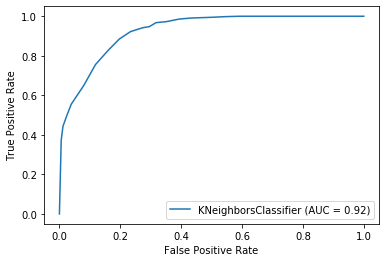

In [12]:
# print roc curve for KNN classifier trained on raw pixels
plot_roc_curve(model_raw, x_test_raw, y_test)
plt.show()

In [20]:
# train a KNN classifier on histogram features
model_hist = KNeighborsClassifier(n_neighbors=20, algorithm = 'kd_tree', n_jobs=8)
model_hist.fit(x_train_hist, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=20, p=2,
                     weights='uniform')

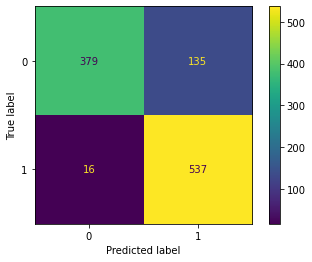

In [21]:
plot_confusion_matrix(model_hist, x_test_hist, y_test, values_format='d')
plt.show()

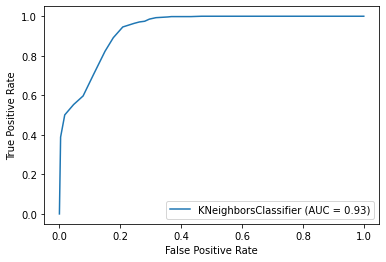

In [22]:
plot_roc_curve(model_hist, x_test_hist, y_test)
plt.show()

In [23]:
## Identifying Waldorf/Statler
# loading the already preprocessed MFCC feature dataset into dataframe
frame_length_ms = 20
n_mfcc_coeffs = 20
ws_raw_data = get_waldorf_statler_mfcc_features(frame_length_ms, n_mfcc_coeffs)
df_ws =  pd.DataFrame(ws_raw_data, columns=['label', 'file_id', 'mfcc'])
df_ws

FileNotFoundError: [Errno 2] No such file or directory: '../../audio/'

In [27]:
# split dataframe into train, test and validation set
train, test, validation = train_test_validation_split(df_ws)

# extract specific columns used for classification
x_train_mfcc = train['mfcc'].tolist()
y_train_mfcc = train['label'].tolist()

x_test_mfcc = test['mfcc'].tolist()
y_test_mfcc = test['label'].tolist()

x_validation_mfcc = validation['mfcc'].tolist()
y_validation_mfcc = validation['label'].tolist()

In [47]:
# train a random forest classifier on mfcc features
ws_rf_cls = RandomForestClassifier(n_estimators=200)
ws_rf_cls.fit(x_train_mfcc, y_train_mfcc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

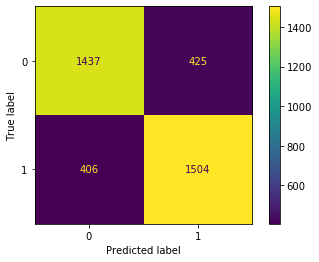

In [48]:
plot_confusion_matrix(ws_rf_cls, x_test_mfcc, y_test_mfcc, values_format='d')
plt.show()

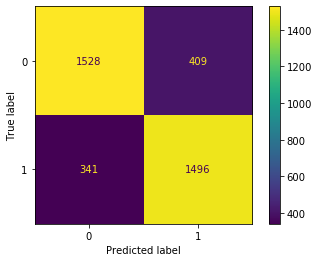

In [49]:
plot_confusion_matrix(ws_rf_cls, x_validation_mfcc, y_validation_mfcc, values_format='d')
plt.show()

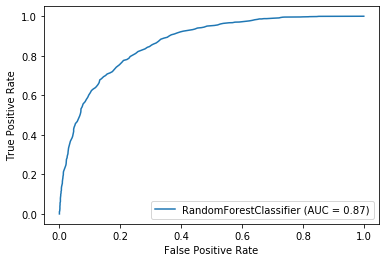

In [50]:
plot_roc_curve(ws_rf_cls, x_test_mfcc, y_test_mfcc)
plt.show()

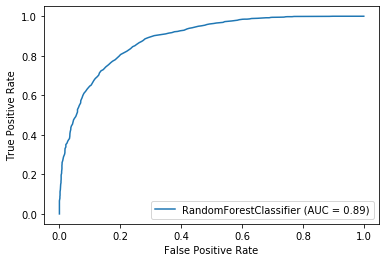

In [51]:
plot_roc_curve(ws_rf_cls, x_validation_mfcc, y_validation_mfcc)
plt.show()